In [1]:
import datetime
import os, sys
import pandas as pd, numpy as np
from backtest import Backtest
from data import HistoricCSVDataHandler
from event import SignalEvent
from execution import SimulatedExecutionHandler
from portfolio import Portfolio
from strategy import Strategy
import fix_yahoo_finance as yf

import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")

%matplotlib inline

This is a double SMA crossover long/short strategy based on 10 largest companies by their market capital across 10 sectors.

In [2]:
def get_yahoo_data_single(symbol, start_str, end_str):
    """
    Documentation: start/end_str is of the format of, e.g. "2017-09-15"
    """
    import_ = yf.download(symbol, start = start_str, end = end_str)
    return import_

In [4]:
class MovingAverageCrossStrategy(Strategy):
    """
    Carries out a basic Moving Average Crossover strategy with a
    short/long simple weighted moving average. Default short/long
    windows are 12/26 periods respectively.
    """

    def __init__(self, bars, events, short_window=12, long_window=26):
        """
        Initialises the buy and hold strategy.

        Parameters:
        bars - The DataHandler object that provides bar information
        events - The Event Queue object.
        short_window - The short moving average lookback.
        long_window - The long moving average lookback.
        """
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window

        # Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()

    def _calculate_initial_bought(self):
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought

    def calculate_signals(self, event):
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.    

        Parameters
        event - A MarketEvent object. 
        """
        if event.type == 'MARKET':
            for symbol in self.symbol_list:
                bars = self.bars.get_latest_bars_values(symbol, "Adj Close", N=self.long_window)

                if bars is not None and bars != []:
                    short_sma = np.mean(bars[-self.short_window:])
                    long_sma = np.mean(bars[-self.long_window:])

                    dt = self.bars.get_latest_bar_datetime(symbol)
                    sig_dir = ""
                    strength = 1.0
                    strategy_id = 1

                    if short_sma > long_sma and self.bought[symbol] == "OUT":
                        sig_dir = 'LONG'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'LONG'

                    elif short_sma < long_sma and self.bought[symbol] == "LONG":
                        sig_dir = 'EXIT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'EXIT'


if __name__ == "__main__":
    # csv_dir = REPLACE_WITH_YOUR_CSV_DIR_HERE
    csv_dir = os.getcwd()
    symbol_list = ['AAPL','AMZN','JNJ','V','XOM','WMT','VZ','BHP','NEE','SPG']
    initial_capital = 1000000.0
    start_date = datetime.datetime(2015,4,1,0,0,0)
    heartbeat = 0.0

    backtest = Backtest(csv_dir, 
                        symbol_list, 
                        initial_capital, 
                        heartbeat,
                        start_date,
                        HistoricCSVDataHandler, 
                        SimulatedExecutionHandler, 
                        Portfolio, 
                        MovingAverageCrossStrategy)
    
    backtest.simulate_trading()

Creating DataHandler, Strategy, Portfolio and ExecutionHandler


FileNotFoundError: File b'/Users/miaoyuesun/Code_Workspace/brad_public_workspace_on_win/backtester/brad_event_driven_backtester/AAPL.csv' does not exist

In [39]:
results = pd.read_csv('equity.csv')
results['datetime'] = pd.to_datetime(results['datetime'])
results.index =  results['datetime']
results['datetime'] = results['datetime'].astype(str)

In [41]:
results.index

DatetimeIndex(['2015-04-01', '2014-04-09', '2014-04-10', '2014-04-11',
               '2014-04-14', '2014-04-15', '2014-04-16', '2014-04-17',
               '2014-04-21', '2014-04-22',
               ...
               '2019-03-28', '2019-03-29', '2019-04-01', '2019-04-02',
               '2019-04-03', '2019-04-04', '2019-04-05', '2019-04-08',
               '2019-04-09', '2019-04-09'],
              dtype='datetime64[ns]', name='datetime', length=1261, freq=None)

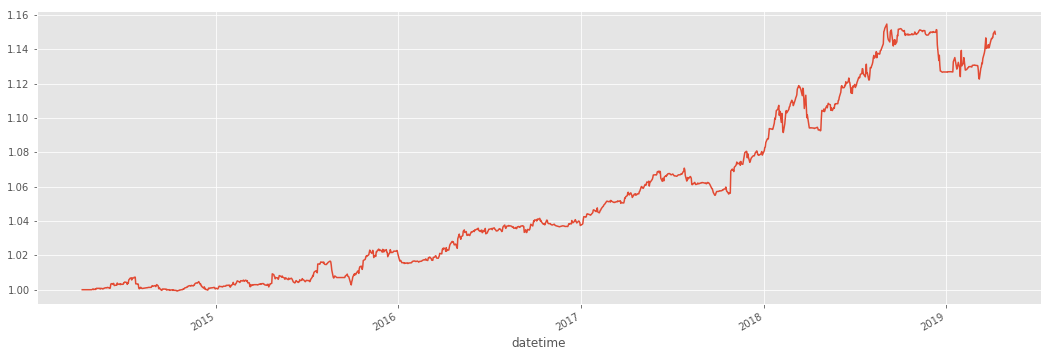

In [42]:
results['equity_curve'].plot(figsize = (18, 6));

In [27]:
spy = get_yahoo_data_single('SPY', '2015-04-01', '2019-04-09')

[*********************100%***********************]  1 of 1 downloaded


In [60]:
spy['pct_chg'] = spy['Adj Close'].pct_change()
spy['spy_equity_curve'] = spy['pct_chg'].cumsum()+1
spy['datetime'] = spy.index
spy['datetime'] = spy['datetime'].astype(str)

In [63]:
merged = results.merge(spy, on = 'datetime')
merged.index = merged['datetime']

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'datetime' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


In [64]:
merged.columns

Index(['datetime', 'AAPL', 'AMZN', 'BHP', 'JNJ', 'NEE', 'SPG', 'V', 'VZ',
       'WMT', 'XOM', 'cash', 'commission', 'total', 'returns', 'equity_curve',
       'drawdown', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'pct_chg', 'equity_curves', 'spy_equity_curve'],
      dtype='object')

In [72]:
benchmark = merged[['equity_curve', 'spy_equity_curve']]

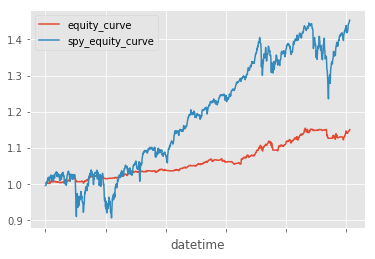

In [78]:
benchmark.plot()

In [ ]:
benchmark